In [66]:
import numpy as np
from pymultifracs import mfa
import matplotlib.pyplot as plt
from pymultifracs.simul import mrw
import pandas as pd
from pymultifracs.utils import build_q_log
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

In [67]:
import import_ipynb
from prep_synth_data import create_synth_data

In [68]:
pd.options.display.float_format = '{:,.2f}'.format

In [69]:
H = .3
lam = .17
N = 1000
length = 65536
L = length
X = mrw(shape=(length,N), H=H, lam=lam, L=L).T

In [70]:
j2max = int(np.log2(length) - 3.1)

In [71]:
def get_df_mfa(signals, n_cumul=2, j1=2, j2=7, q = [-10, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 10],p_exp=np.inf):
    results = []
    for signal in signals:
        result = dict()
        dwt, lwt = mfa.mf_analysis_full(
        signal,
        scaling_ranges=[(j1, j2)],
        q= q, #[-10, -5,-3,-2, 0,2,3, 5, 10], #[-4,-3,-2,1,0,1,2,3,4],# [-10, -5, -2, 0, 2, 5, 10],#build_q_log(1, 10, 20), # q=[-10, -5, 0, 5, 10],
        n_cumul=n_cumul,
        p_exp=p_exp,
        gamint=0.0
        )
        lwt_sf, lwt_cumul, lwt_mfs, lwt_hmin = lwt
        sf, cumul, mfs, hmin = dwt

        def get_item(arr):
            return arr.item() if isinstance(arr,np.ndarray) else lwt_hmin

        result['std'] = signal.std()
        result['hmin'] = hmin.item()
        result['l_hmin'] = get_item(lwt_hmin) # lwt_hmin.item() if isinstance(lwt_hmin,np.ndarray) else lwt_hmin

        result['deg_h'] = mfs.hq.max() - mfs.hq.min()
        result['l_deg_h'] = lwt_mfs.hq.max() - lwt_mfs.hq.min()
        result['H'] = get_item(sf.H)
        result['l_H'] = get_item(lwt_sf.H)

        for i in range(n_cumul):
            result[f'cumul{i}'] = get_item(cumul.log_cumulants[i])
            result[f'l_cumul{i}'] = get_item(lwt_cumul.log_cumulants[i])
        
        for i in range(sf.zeta.shape[0]):
            result[f' zeta(q={sf.q[i]})'] = sf.zeta[i, 0, 0]
            result[f' zeta(q={lwt_sf.q[i]})'] = lwt_sf.zeta[i, 0, 0]

        results.append(result)
    return pd.DataFrame(results)

In [72]:
df_mfa = get_df_mfa(X,n_cumul=4)

In [73]:
columns = df_mfa.columns
df_mfa.describe()[1:3]

,std,hmin,deg_h,l_deg_h,H,l_H,cumul0,l_cumul0,cumul1,l_cumul1,...,zeta(q=-4),zeta(q=-3),zeta(q=-2),zeta(q=-1),zeta(q=1),zeta(q=2),zeta(q=3),zeta(q=4),zeta(q=5),zeta(q=10)
mean,1.00,0.09,1.30,0.53,0.29,0.28,0.31,0.31,-0.02,-0.04,...,-1.59,-1.12,-0.71,-0.33,0.29,0.55,0.78,0.97,1.12,1.61
std,0.40,0.06,0.44,0.09,0.01,0.01,0.01,0.00,0.03,0.00,...,0.05,0.03,0.01,0.00,0.01,0.01,0.03,0.06,0.10,0.42


In [74]:
def create_visibility_options(n):
    visibility_options = {}

    # Add the "All" option
    visibility_options["All"] = [True] * n
    
    # Add options for each individual curve
    for i in range(n):
        visibility = [False] * n
        visibility[i] = True
        visibility_options[f"Curve {i + 1}"] = visibility
    
    # Add the "None" option
    visibility_options["None"] = [False] * n

    return visibility_options

def create_buttons(n, labels = None):
    visibility_options = create_visibility_options(n)
    
    if labels is None:
        labels = list(visibility_options.keys())
    labels = ["All"] + labels + ["None"]
    buttons = list()
    
    for label, visibility in zip(labels,visibility_options.values()):
        buttons.append(dict(label=label,method='update',args=[{"visible":visibility}]))
    return buttons

def dyn_plot(y, y_err, label=None, x=None):
    fig = go.Figure()

    y = np.squeeze(y)

    if len(y.shape)<=1:
        y = np.expand_dims(y,axis=0)

    nb_curves = y.shape[0]

    if x is None:
        x = range(y.shape[-1])

    if label is None:
        label = ['Curve ' + str(i) for  i in range(nb_curves)]
    
    
    buttons = create_buttons(nb_curves, labels=label)


    # Create the figure
    fig = go.Figure()
    for i in range(nb_curves):
        # Add the curves
        fig.add_trace(go.Scatter(x=x, y=y[i], mode='lines', name=label[i],
            error_y=dict(
            type='data',
            array=y_err[i],
            visible=True
        )))

    nb_per_row = 15
    len_buttons = len(buttons)
    nb_rows = len_buttons // nb_per_row + 1 *(len_buttons % nb_per_row > 0)
    updatemenus = [
    dict(
        type="buttons",
        direction="right",
        buttons=buttons[i*nb_per_row: (i+1)*nb_per_row],
        x=0.1,
        xanchor="left",
        y=1.15 - 0.1 * i,
        yanchor="top"
    )
        for i in range(nb_rows)
    ]
    update_menus = []
    # Update layout with interactive options
    fig.update_layout(
    title="Interactive Plot with Toggle Curves",
    xaxis_title="X Axis",
    yaxis_title="Y Axis",
    legend_title="Curves",
    updatemenus=updatemenus
    )

    # Show the figure
    fig.show()
        

In [75]:
["All"] + list(columns) + ["None"]

['All',
 'std',
 'hmin',
 'l_hmin',
 'deg_h',
 'l_deg_h',
 'H',
 'l_H',
 'cumul0',
 'l_cumul0',
 'cumul1',
 'l_cumul1',
 'cumul2',
 'l_cumul2',
 'cumul3',
 'l_cumul3',
 ' zeta(q=-10)',
 ' zeta(q=-5)',
 ' zeta(q=-4)',
 ' zeta(q=-3)',
 ' zeta(q=-2)',
 ' zeta(q=-1)',
 ' zeta(q=1)',
 ' zeta(q=2)',
 ' zeta(q=3)',
 ' zeta(q=4)',
 ' zeta(q=5)',
 ' zeta(q=10)',
 'None']

In [76]:
np.array(df_mfa.mean(axis=0),dtype=np.float32)

array([ 9.9927664e-01,  8.8889636e-02,            nan,  1.3040857e+00,
        5.2860659e-01,  2.8543469e-01,  2.7605370e-01,  3.0948803e-01,
        3.1268471e-01, -2.4842286e-02, -3.8221002e-02,  8.5426401e-03,
        2.6250170e-03, -7.4401982e-02, -3.7032535e-04, -5.0034175e+00,
       -2.0970318e+00, -1.5874854e+00, -1.1231318e+00, -7.0556903e-01,
       -3.3224824e-01,  2.9399502e-01,  5.5210739e-01,  7.7582788e-01,
        9.6530974e-01,  1.1213461e+00,  1.6089361e+00], dtype=float32)

In [77]:
signals_mean = []
signals_std = []
j2s = range(4,j2max)
for j2 in j2s:
    df_mfa = get_df_mfa(X,n_cumul=4,j1=1,j2=j2)
    y = np.array(np.mean(df_mfa, axis = 0),dtype=np.float32)
    y_std = np.array(np.std(df_mfa, axis = 0),dtype=np.float32)
    signals_mean.append(y)
    signals_std.append(y_std)
signals_mean = np.array(signals_mean).T
signals_std = np.array(signals_std).T

In [78]:
dyn_plot(signals_mean, signals_std, label=list(columns), x=list(j2s))

In [79]:
qs = [[-10, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 10], build_q_log(1, 10, 12)]

signals_mean = []
signals_std = []
for q in qs:
    df_mfa = get_df_mfa(X,n_cumul=4,j1=2,j2=j2,q=q)
    y = np.array(np.mean(df_mfa, axis = 0),dtype=np.float32)[:15]
    y_std = np.array(np.std(df_mfa, axis = 0),dtype=np.float32)[:15]
    signals_mean.append(y)
    signals_std.append(y_std)
signals_mean = np.array(signals_mean).T
signals_std = np.array(signals_std).T

In [80]:
dyn_plot(signals_mean, signals_std, label=list(columns), x=list(range(len(qs))))

In [82]:
p_exps = [1,2,3,np.inf]

signals_mean = []
signals_std = []
for p_exp in p_exps:
    df_mfa = get_df_mfa(X,n_cumul=4,j1=2,j2=j2,p_exp=p_exp)
    y = np.array(np.mean(df_mfa, axis = 0),dtype=np.float32)
    y_std = np.array(np.std(df_mfa, axis = 0),dtype=np.float32)
    signals_mean.append(y)
    signals_std.append(y_std)
signals_mean = np.array(signals_mean).T
signals_std = np.array(signals_std).T


In [84]:
dyn_plot(signals_mean, signals_std, label=list(columns), x=list(range(len(p_exps))))

In [ ]:
H1 = 0.8
H2 = 0.3

lamdba1 = .17
lamdba2 = .17

n_per_class = 1000
length = 2048 #65536
L = length
X1 =  mrw(shape=(length,n_per_class), H=H1, lam=lamdba1, L=L).T
X2 =  mrw(shape=(length,n_per_class), H=H2, lam=lamdba2, L=L).T

In [ ]:
data = np.load('hrv_data_good.npy')
X, y = data[:,:-1], data[:,-1]

In [ ]:
X1 = X[np.where(1-y)]
X2 = X[np.where(y)]

In [ ]:
j2max = int(np.log2(X.shape[-1]) - 3.1)

In [ ]:
signals_mean = []
signals_std = []
j2s = range(4,j2max)
for j2 in j2s:
    df_mfa = get_df_mfa(X1,n_cumul=4,j1=1,j2=j2)
    y = np.array(np.mean(df_mfa, axis = 0),dtype=np.float32)
    y_std = np.array(np.std(df_mfa, axis = 0),dtype=np.float32)
    signals_mean.append(y)
    signals_std.append(y_std)
signals_mean = np.array(signals_mean).T
signals_std = np.array(signals_std).T
dyn_plot(signals_mean, signals_std, label=columns, x=list(j2s))


c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\utils.py:87: RuntimeWarning:

divide by zero encountered in power

c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\utils.py:76: RuntimeWarning:

divide by zero encountered in reciprocal

c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\cumulants.py:265: RuntimeWarning:

divide by zero encountered in log

c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:117: RuntimeWarning:

invalid value encountered in divide

c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:118: RuntimeWarning:

divide by zero encountered in log2

c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:118: RuntimeWarning:

invalid value encountered in multiply

c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:119: RuntimeWarning:

divide by zero encountered in log2

c:

In [ ]:
X1.shape

(173, 10000)

In [ ]:
# result = {'Transformation (shape)': trans_name_str}
#         result["shape"] = trans_X.shape[-1]
#         result['nb_trans'] = len(trans)

#         scaler = StandardScaler()
#         trans_X = scaler.fit_transform(trans_X) 
#         print(f"Transformation: {trans_name_str}, Shape: {trans_X.shape[-1]} ")
#         for clf_name, clf in classifiers.items():
#             kf = KFold(n_splits=5, shuffle=True, random_state=42)
#             scores = cross_val_score(clf, trans_X, y, cv=kf, scoring='accuracy')
#             result[f'{clf_name} accuracy'] = np.mean(scores)
#             result[f'{clf_name} std'] = np.std(scores)
#             print(f"Classifier: {clf_name}, "
#                   f"Mean Accuracy: {np.mean(scores):.3f}, Std Accuracy: {np.std(scores):.3f}")
        
#         results.append(result)

In [ ]:
signal = X1[0]
dwt, lwt = mfa.mf_analysis_full(
        signal,
        scaling_ranges=[(2, 4)],
        q=[-10, -5, 0, 5, 10],
        n_cumul=2,
        p_exp=np.inf,
        gamint=0.0
        )
lwt_sf, lwt_cumul, lw_mfs, lwt_hmin = lwt
sf, cumul, mfs, hmin = dwt


In [ ]:
lwt_cumul.log_cumulants

array([[[ 0.28961673]],

       [[-0.08598032]]])

In [ ]:
hmin

array([[-0.58835444]])

In [ ]:
# sf.H

In [ ]:
n_cumul = 4

In [ ]:
scaler = StandardScaler()

In [ ]:
df_mfa1 = get_df_mfa(X1, n_cumul=n_cumul)
ndf_mfa1 = get_df_mfa(scaler.fit_transform(X1), n_cumul=n_cumul)
df_mfa2 = get_df_mfa(X2, n_cumul=n_cumul)
ndf_mfa2 = get_df_mfa(scaler.fit_transform(X2), n_cumul=n_cumul)

c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\utils.py:87: RuntimeWarning:

divide by zero encountered in power

c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\utils.py:76: RuntimeWarning:

divide by zero encountered in reciprocal

c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\cumulants.py:265: RuntimeWarning:

divide by zero encountered in log

c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:117: RuntimeWarning:

invalid value encountered in divide

c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:118: RuntimeWarning:

divide by zero encountered in log2

c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:118: RuntimeWarning:

invalid value encountered in multiply

c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:119: RuntimeWarning:

divide by zero encountered in log2

c:

In [ ]:
df_mfa1.describe() # include='all')

,std,hmin,deg_h,l_deg_h,H,l_H,cumul0,l_cumul0,cumul1,l_cumul1,...,zeta(q=-4),zeta(q=-3),zeta(q=-2),zeta(q=-1),zeta(q=1),zeta(q=2),zeta(q=3),zeta(q=4),zeta(q=5),zeta(q=10)
count,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,...,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00
mean,0.15,-0.48,1.42,0.63,-0.30,0.23,-0.22,0.33,-0.09,-0.11,...,-1.69,-1.21,-0.78,-0.37,0.27,0.45,0.57,0.65,0.72,0.88
std,0.07,0.16,0.86,0.24,0.22,0.09,0.27,0.17,0.18,0.21,...,0.87,0.64,0.43,0.21,0.13,0.17,0.17,0.15,0.15,0.21
min,0.03,-0.93,0.39,0.31,-0.55,0.12,-0.59,0.14,-0.73,-0.77,...,-4.69,-3.39,-2.10,-0.97,0.13,0.24,0.32,0.22,-0.06,-1.52
25%,0.11,-0.59,0.94,0.44,-0.45,0.17,-0.44,0.20,-0.16,-0.11,...,-2.08,-1.52,-1.04,-0.48,0.18,0.34,0.46,0.57,0.65,0.84
50%,0.15,-0.50,1.38,0.56,-0.37,0.19,-0.33,0.23,-0.05,-0.03,...,-1.35,-0.94,-0.58,-0.26,0.21,0.37,0.51,0.62,0.70,0.92
75%,0.20,-0.41,1.66,0.71,-0.22,0.25,0.04,0.46,0.02,-0.02,...,-1.05,-0.73,-0.46,-0.21,0.35,0.51,0.61,0.72,0.80,0.97
max,0.39,0.13,7.13,1.43,0.44,0.47,0.45,0.82,0.23,0.30,...,-0.79,-0.58,-0.35,-0.16,0.63,0.95,1.08,1.11,1.18,1.11


In [ ]:
ndf_mfa1.describe() # include='all')

,std,hmin,deg_h,l_deg_h,H,l_H,cumul0,l_cumul0,cumul1,l_cumul1,...,zeta(q=-4),zeta(q=-3),zeta(q=-2),zeta(q=-1),zeta(q=1),zeta(q=2),zeta(q=3),zeta(q=4),zeta(q=5),zeta(q=10)
count,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,...,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00
mean,0.63,-0.48,1.33,0.55,-0.30,0.22,-0.26,0.29,-0.05,-0.07,...,-1.45,-1.04,-0.67,-0.32,0.25,0.43,0.56,0.65,0.72,0.90
std,0.27,0.16,0.47,0.19,0.20,0.07,0.22,0.13,0.13,0.14,...,0.66,0.48,0.32,0.16,0.10,0.15,0.15,0.14,0.13,0.10
min,0.12,-0.82,0.55,0.31,-0.54,0.12,-0.58,0.15,-0.51,-0.51,...,-3.86,-2.77,-1.70,-0.73,0.14,0.25,0.34,0.40,0.45,0.61
25%,0.45,-0.58,0.95,0.42,-0.45,0.17,-0.44,0.19,-0.12,-0.10,...,-1.62,-1.17,-0.79,-0.36,0.18,0.34,0.46,0.57,0.65,0.85
50%,0.61,-0.49,1.30,0.49,-0.37,0.19,-0.34,0.23,-0.05,-0.03,...,-1.19,-0.83,-0.52,-0.25,0.21,0.37,0.51,0.62,0.70,0.91
75%,0.80,-0.41,1.64,0.61,-0.23,0.24,-0.06,0.36,0.02,-0.02,...,-1.02,-0.72,-0.46,-0.21,0.31,0.48,0.60,0.71,0.79,0.97
max,1.52,0.18,2.68,1.25,0.32,0.42,0.26,0.64,0.30,0.16,...,-0.82,-0.57,-0.35,-0.16,0.55,0.83,1.01,1.06,1.05,1.20


In [ ]:
df_mfa2.describe()

,std,hmin,deg_h,l_deg_h,H,l_H,cumul0,l_cumul0,cumul1,l_cumul1,...,zeta(q=-4),zeta(q=-3),zeta(q=-2),zeta(q=-1),zeta(q=1),zeta(q=2),zeta(q=3),zeta(q=4),zeta(q=5),zeta(q=10)
count,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,...,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00
mean,0.11,-0.33,1.42,0.73,-0.08,0.31,0.01,0.41,-0.05,-0.05,...,-2.18,-1.58,-1.01,-0.49,0.37,0.61,0.73,0.79,0.83,0.90
std,0.07,0.13,0.77,0.78,0.11,0.08,0.12,0.12,0.16,0.12,...,3.03,2.25,1.45,0.65,0.10,0.16,0.18,0.18,0.18,0.25
min,0.04,-0.85,0.45,0.32,-0.42,0.08,-0.37,0.09,-0.84,-0.61,...,-30.05,-22.22,-14.31,-6.43,0.09,0.17,0.24,0.15,-0.16,-1.75
25%,0.07,-0.42,1.11,0.55,-0.15,0.28,-0.08,0.34,-0.13,-0.10,...,-2.16,-1.55,-1.01,-0.50,0.31,0.55,0.67,0.76,0.78,0.86
50%,0.09,-0.33,1.32,0.63,-0.07,0.33,0.02,0.40,-0.04,-0.02,...,-1.81,-1.31,-0.85,-0.42,0.37,0.66,0.79,0.85,0.88,0.97
75%,0.13,-0.26,1.65,0.74,-0.00,0.36,0.08,0.50,0.06,0.03,...,-1.52,-1.09,-0.71,-0.34,0.45,0.72,0.85,0.91,0.94,1.00
max,0.48,0.02,7.69,7.89,0.17,0.44,0.24,0.67,0.29,0.16,...,-1.03,-0.54,-0.25,-0.10,0.55,0.89,1.10,1.16,1.18,1.28


In [ ]:
ndf_mfa2.describe() 

,std,hmin,deg_h,l_deg_h,H,l_H,cumul0,l_cumul0,cumul1,l_cumul1,...,zeta(q=-4),zeta(q=-3),zeta(q=-2),zeta(q=-1),zeta(q=1),zeta(q=2),zeta(q=3),zeta(q=4),zeta(q=5),zeta(q=10)
count,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,...,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00,173.00
mean,0.64,-0.33,1.36,0.56,-0.07,0.30,-0.01,0.38,-0.03,-0.03,...,-1.61,-1.18,-0.77,-0.38,0.35,0.60,0.72,0.79,0.82,0.90
std,0.34,0.12,0.51,0.14,0.10,0.08,0.11,0.10,0.13,0.10,...,0.40,0.29,0.20,0.10,0.09,0.15,0.17,0.18,0.18,0.24
min,0.23,-0.56,0.49,0.37,-0.43,0.08,-0.35,0.09,-0.48,-0.44,...,-3.85,-2.68,-1.56,-0.68,0.08,0.16,0.23,0.16,-0.12,-1.58
25%,0.43,-0.41,0.97,0.48,-0.15,0.27,-0.08,0.32,-0.11,-0.08,...,-1.79,-1.32,-0.88,-0.44,0.30,0.54,0.66,0.75,0.79,0.86
50%,0.52,-0.33,1.35,0.53,-0.07,0.32,-0.00,0.38,-0.03,-0.00,...,-1.56,-1.16,-0.77,-0.39,0.36,0.63,0.78,0.84,0.88,0.97
75%,0.72,-0.25,1.71,0.60,-0.00,0.35,0.06,0.45,0.04,0.04,...,-1.30,-0.95,-0.62,-0.32,0.43,0.70,0.84,0.90,0.94,1.00
max,1.88,0.03,3.84,1.21,0.17,0.43,0.23,0.59,0.40,0.15,...,-0.96,-0.52,-0.24,-0.10,0.50,0.85,1.07,1.17,1.20,1.25


In [ ]:
def get_mfa_representation(signals, n_cumul=2):
    representations = []
    for signal in signals:
        representation = []
       
        dwt, lwt = mfa.mf_analysis_full(
        signal,
        scaling_ranges=[(2, 4)],
        q= [-10, -5, -2, 0, 2, 5, 10],#build_q_log(1, 10, 20), # q=[-10, -5, 0, 5, 10],
        n_cumul=n_cumul,
        p_exp=np.inf,
        gamint=0.0
        )
        lwt_sf, lwt_cumul, lwt_mfs, lwt_hmin = lwt
        sf, cumul, mfs, hmin = dwt

        def get_item(arr):
            return arr.item() if isinstance(arr,np.ndarray) else lwt_hmin

        representation.append(signal.std())

        representation.append(lwt_mfs.hq.max() - lwt_mfs.hq.min())
        representation.append(lwt_sf.H.item())

        for i in range(n_cumul):
            representation.append(lwt_cumul.log_cumulants[i].item())
            
        representations.append(representation)
    return np.array(representations)

In [ ]:
X_mfa = get_mfa_representation(scaler.fit_transform(X),n_cumul=3)


In [ ]:
# x1 = np.array(df_mfa1)
# y1 = np.zeros((x1.shape[0],1))
# x2 = np.array(df_mfa2)
# y2 = np.zeros((x2.shape[0],1))

# x = np.concatenate([x1,x2],axis=0)
# y = np.concatenate([y1,y2],axis=0)


In [ ]:
svc = SVC(kernel='linear')
scaler = StandardScaler()
nX_mfa = scaler.fit_transform(X_mfa)
svc.fit(nX_mfa,y)

ValueError: Input y contains NaN.

        Weight
std      -0.26
deg_h     0.01
H         0.77
cumul0    0.45
cumul1   -0.29
cumul2    0.79


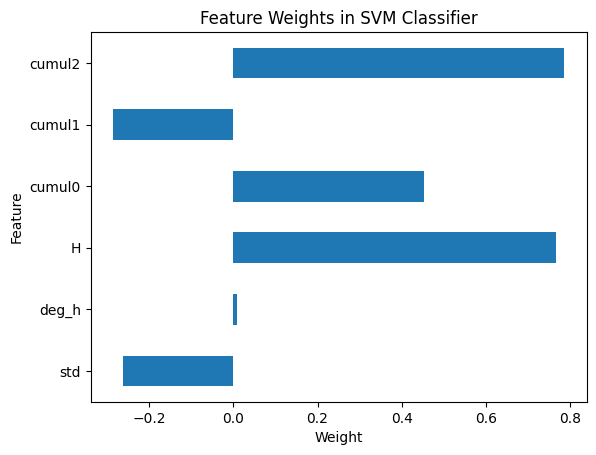

In [ ]:
# Step 5: Access and Analyze Weights
# The coefficients (weights) of the features for a linear SVM
weights = svc.coef_

# For visualization purposes
features = ['std','deg_h','H'] + [f'cumul{i}' for i in range(X_mfa.shape[-1] - 3)]
weights_df = pd.DataFrame(weights.T, index=features, columns=['Weight'])
print(weights_df)

# Step 6: Visualize Weights
weights_df.plot(kind='barh', legend=False)
plt.title('Feature Weights in SVM Classifier')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.show()